In [14]:
import pybaseball as pb
import pandas as pd

In [15]:
# Function to calculate pitch usage by count and batter handedness
def get_usage(df: pd.DataFrame, by_hand = True) -> dict:
    if by_hand == True:
        usage_dict = {}

        # Create Count columns
        df['Count'] = df['balls'].astype(str) + '-' + df['strikes'].astype(str)

        # Calculate pitch usage by count and batter handedness
        usage = df.groupby(['Count', 'pitch_type', 'stand'])['pitch_type'].count().reset_index(name = 'Usage')

        # Reshape the DataFrame to have pitch types and batter handedness as columns
        usage = usage.pivot(index = 'Count', columns = ['pitch_type', 'stand'], values = 'Usage').fillna(0).astype(object).reset_index()

        # Reformat column names for easier access
        usage.columns = [
            f"{col[0]}_{col[1]}" if isinstance(col, tuple) else col
            for col in usage.columns
        ]
        usage.rename(columns = {'Count_' : 'Count'}, inplace = True)

        # Calculate pitch usage percentages by handedness
        for index, row in usage.iterrows():
            # Split by L and R
            l_total = 0
            r_total = 0

            # Calculate totals for L and R
            for col in usage.columns[1:]:
                if col.endswith('_L'):
                    l_total += row[col]
            for col in usage.columns[1:]:
                if col.endswith('_R'):
                    r_total += row[col]

            # Calculate percentages
            for pt in usage.columns[1:]:
                if pt.endswith('_L'):
                    total = l_total
                else:
                    total = r_total
                usage.loc[index, pt] = f"{usage.loc[index, pt] / total:.1%}"

        # Create separate DataFrames for lefty and righty usage
        lefty_usage = usage[['Count'] + [col for col in usage.columns if col.endswith('_L')]]
        righty_usage = usage[['Count'] + [col for col in usage.columns if col.endswith('_R')]]

        # Clean up column names
        lefty_usage.columns = [col.replace('_L', '') for col in lefty_usage.columns]
        righty_usage.columns = [col.replace('_R', '') for col in righty_usage.columns]

        # Append to usage dictionary
        usage_dict['L'] = lefty_usage
        usage_dict['R'] = righty_usage

        # Return the dictionary containing lefty and righty usage DataFrames
        return usage_dict
    else:
        usage_dict = {}

        # Create Count columns
        df['Count'] = df['balls'].astype(str) + '-' + df['strikes'].astype(str)

        # Calculate pitch usage by count
        usage = df.groupby(['Count', 'pitch_type'])['pitch_type'].count().reset_index(name = 'Usage')

        # Reshape the DataFrame to have pitch types as column
        usage = usage.pivot(index = 'Count', columns = ['pitch_type'], values = 'Usage').fillna(0).astype(object).reset_index()


        # Calculate pitch usage percentages by handedness
        for index, row in usage.iterrows():
            total = 0
            # Calculate total by row
            for col in usage.columns[1:]:
                total += row[col]

            # Calculate percentages
            for pt in usage.columns[1:]:
                usage.loc[index, pt] = f"{usage.loc[index, pt] / total:.1%}"

        usage_dict['all'] = usage.reset_index()

        # Return the list containing the single dataframe
        return usage_dict

In [16]:
data_subset = pd.read_parquet('./data/statcast_data_2025.parquet')
brown_id = pb.playerid_lookup('Brown', 'Hunter')
brown_data = data_subset[data_subset['pitcher'] == brown_id['key_mlbam'][0]].copy()
king_id = pb.playerid_lookup('King', 'Bryan')
king_data = data_subset[data_subset['pitcher'] == king_id['key_mlbam'][0]].copy()
project_data = pd.concat([brown_data, king_data], ignore_index = True)
project_data.head()
project_data.to_csv('./project_data.csv', index = False)

In [ ]:
data = pd.read_parquet('data/statcast_data_2025.parquet')

first_name = input("Enter player's first name: ")
last_name = input("Enter player's last name: ")
player_id = pb.playerid_lookup(last_name, first_name)

by_hand = True

try:
    player_stats = data[data['pitcher'] == player_id['key_mlbam'][0]].copy()
    player_usage = get_usage(player_stats, by_hand = by_hand)
    if by_hand == False:
        player_usage = player_usage['all']
        print(f"Pitch Usage for {first_name} {last_name}:")
        display(player_usage)
    else:
        player_lefty_usage = player_usage['L']
        player_righty_usage = player_usage['R']
        print(f"Pitch Usage for {first_name} {last_name}:")
        print("Pitch Usage Against Left-handed hitters:")
        display(player_lefty_usage)
        print("Pitch Usage Against Right-handed hitters:")
        display(player_righty_usage)
except Exception as e:
    print(f"Error retrieving data for {first_name} {last_name}: {e}")
    exit()

Pitch Usage for Hunter Brown:
Pitch Usage Against Left-handed hitters:


,Count,CH,FC,FF,KC,SI,SL
0,0-0,14.8%,3.0%,49.7%,19.1%,11.2%,2.2%
1,0-1,15.1%,1.2%,47.6%,27.7%,7.8%,0.6%
2,0-2,15.7%,1.1%,47.2%,36.0%,0.0%,0.0%
3,1-0,17.9%,5.8%,42.8%,14.5%,18.5%,0.6%
4,1-1,22.0%,3.0%,41.5%,23.8%,7.9%,1.8%
5,1-2,19.4%,2.3%,44.6%,30.3%,3.4%,0.0%
6,2-0,36.1%,4.9%,34.4%,6.6%,14.8%,3.3%
7,2-1,44.3%,0.0%,29.1%,13.9%,12.7%,0.0%
8,2-2,16.9%,2.0%,46.6%,24.3%,8.8%,1.4%
9,3-0,0.0%,6.2%,75.0%,0.0%,18.8%,0.0%


Pitch Usage Against Right-handed hitters:


,Count,CH,FC,FF,KC,SI,SL
0,0-0,1.2%,6.1%,27.8%,16.4%,40.4%,8.2%
1,0-1,1.2%,8.0%,28.8%,17.2%,36.8%,8.0%
2,0-2,2.9%,13.0%,47.8%,23.2%,8.7%,4.3%
3,1-0,0.0%,8.8%,24.8%,8.8%,43.1%,14.6%
4,1-1,1.5%,8.2%,30.6%,9.0%,41.8%,9.0%
5,1-2,2.6%,13.9%,37.4%,21.7%,20.0%,4.3%
6,2-0,2.0%,6.1%,18.4%,2.0%,61.2%,10.2%
7,2-1,7.2%,7.2%,26.1%,10.1%,39.1%,10.1%
8,2-2,4.1%,14.3%,36.7%,16.3%,21.4%,7.1%
9,3-0,6.7%,0.0%,33.3%,0.0%,60.0%,0.0%


In [25]:
player_lefty_usage.to_csv("hb_lefty.csv", index = False)
player_righty_usage.to_csv("hb_righty.csv", index = False)

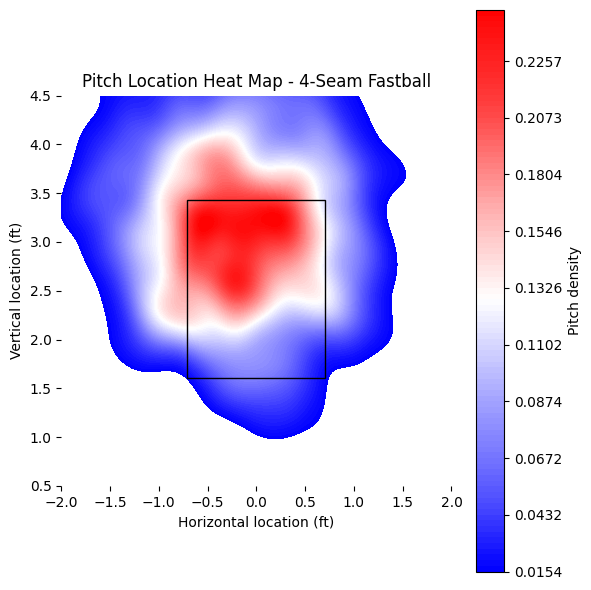

In [19]:
# Need to turn into function

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

df = player_stats[['pitch_name', 'plate_x', 'plate_z', 'sz_top', 'sz_bot']].dropna(subset = ['plate_x','plate_z'])

# Pick a random pitch for testing
pitch = np.random.choice(df['pitch_name'].unique())
df = df[df['pitch_name'] == pitch]

plt.figure(figsize = (6,6))
ax = sns.kdeplot(
    data = df,
    x = 'plate_x',
    y = 'plate_z',
    fill = True,
    cmap = 'bwr',
    bw_adjust = 0.75,
    levels = 100,
    thresh = 0.05,
    cbar = True,
    cbar_kws = {'label' : 'Pitch density'}
)

# horizontal plate half-width in feet (17 inches plate)
plate_half = 17 / 12 / 2.0  # 0.70833 ft

# choose strike zone bounds: prefer per-pitch sz_top/sz_bot; else median per-batter; else global median
if 'sz_top' in df.columns and df['sz_top'].notna().any():
    zone_top = df['sz_top'].median()
    zone_bot = df['sz_bot'].median()
else:
    # fallback approximate (typical adult)
    zone_top, zone_bot = 3.5, 1.5

# Use median horizontal center (usually 0). If you want batter-specific center, compute by handedness/stance.
zone_left, zone_right = -plate_half, plate_half

# draw semi-transparent rectangle for strike zone
rect = plt.Rectangle((zone_left, zone_bot),
                     zone_right - zone_left,
                     zone_top - zone_bot,
                     fill=True, edgecolor='k', linewidth=1.0, facecolor='none', alpha=1.0)
ax.add_patch(rect)


plt.xlim(-2, 2)
plt.ylim(0.5, 4.5)
ax.set_aspect('equal', adjustable='box')
ax.set_xlabel('Horizontal location (ft)')
ax.set_ylabel('Vertical location (ft)')
ax.set_title(f'Pitch Location Heat Map - {pitch}')

sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()


In [20]:
# Needs work

import pandas as pd
from great_tables import GT

def plot_usage(usage: pd.DataFrame) -> dict:

    df = usage.copy()

    # Convert percentage strings to numeric
    for col in df.columns[1:]:
        if df[col].dtype == 'object':
            df[col] = df[col].str.rstrip('%').astype(float)
        else:
            df[col] = df[col].astype(float)

    # Split Count into Balls and Strikes
    df[['Balls', 'Strikes']] = df.iloc[:, 0].astype(str).str.split('-', expand=True).astype(int)

    # All columns except Count, Balls, Strikes
    pitch_types = df.columns[1:-2]

    gt_tables = {}

    for pitch in pitch_types:
        # Pivot table: Rows = Balls, Columns = Strikes
        pivot = df.pivot(index='Balls', columns='Strikes', values=pitch)
        
        # Convert columns to strings for GT
        pivot.columns = pivot.columns.astype(str)
        pivot.columns.name = None
        
        # Reset index to use 'Balls' as a column
        pivot_numeric = pivot.reset_index()
        
        # Rename the index column to empty string
        pivot_numeric.rename(columns={'Balls': ''}, inplace=True)
        
        # Get the list of columns to format and color (all except the first)
        value_columns = list(pivot_numeric.columns[1:])
        
        # Create GT table from the NUMERIC data
        gt_table = (
            GT(pivot_numeric)
            .tab_header(title=f"{pitch} Usage by Count")
            .data_color(
                columns=value_columns,
                palette=['blue', 'white', 'red'],
                domain=[0, 100]  # <-- Set the absolute scale from 0 to 100
            )
            .fmt_number( # Format the numbers as "xx.x%" after coloring
                columns=value_columns,
                decimals=1,
                pattern="{x}%"
            )
        )
        
        gt_tables[pitch] = gt_table

    return gt_tables

In [21]:
test = plot_usage(player_usage['R'])
# Get key names
test.keys()
test['FF']

GT(_tbl_data=         0     1     2
0  0  27.8  28.8  47.8
1  1  24.8  30.6  37.4
2  2  18.4  26.1  36.7
3  3  33.3  22.6  36.7, _body=<great_tables._gt_data.Body object at 0x7baee6a7cfd0>, _boxhead=Boxhead([ColInfo(var='', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='right', column_width=None), ColInfo(var='0', type=<ColInfoTypeEnum.default: 1>, column_label='0', column_align='right', column_width=None), ColInfo(var='1', type=<ColInfoTypeEnum.default: 1>, column_label='1', column_align='right', column_width=None), ColInfo(var='2', type=<ColInfoTypeEnum.default: 1>, column_label='2', column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x7baee6aa6920>, _spanners=Spanners([]), _heading=Heading(title='FF Usage by Count', subtitle=None, preheader=None), _stubhead=None, _source_notes=[], _footnotes=[], _styles=[StyleInfo(locname=LocBody(columns='0', rows=[0], mask=None), grpname=None, colname='0', rownum=0, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#8e8eff')]), StyleInfo(locname=LocBody(columns='0', rows=[1], mask=None), grpname=None, colname='0', rownum=1, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#7e7eff')]), StyleInfo(locname=LocBody(columns='0', rows=[2], mask=None), grpname=None, colname='0', rownum=2, colnum=None, styles=[CellStyleText(color='#FFFFFF', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#5e5eff')]), StyleInfo(locname=LocBody(columns='0', rows=[3], mask=None), grpname=None, colname='0', rownum=3, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#aaaaff')]), StyleInfo(locname=LocBody(columns='1', rows=[0], mask=None), grpname=None, colname='1', rownum=0, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#9393ff')]), StyleInfo(locname=LocBody(columns='1', rows=[1], mask=None), grpname=None, colname='1', rownum=1, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#9c9cff')]), StyleInfo(locname=LocBody(columns='1', rows=[2], mask=None), grpname=None, colname='1', rownum=2, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#8585ff')]), StyleInfo(locname=LocBody(columns='1', rows=[3], mask=None), grpname=None, colname='1', rownum=3, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#7373ff')]), StyleInfo(locname=LocBody(columns='2', rows=[0], mask=None), grpname=None, colname='2', rownum=0, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#f4f4ff')]), StyleInfo(locname=LocBody(columns='2', rows=[1], mask=None), grpname=None, colname='2', rownum=1, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate

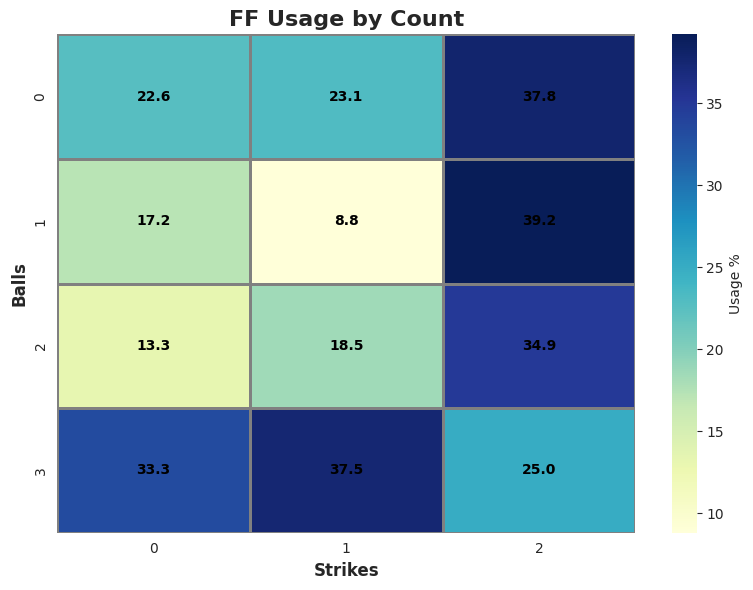

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Copy your DataFrame
df = player_lefty_usage.copy()

# Convert percentages to numeric
for col in df.columns[1:]:
    df[col] = df[col].str.rstrip('%').astype(float)

# Split Count into Balls and Strikes
df[['Balls', 'Strikes']] = df['Count'].str.split('-', expand=True).astype(int)

# Pick a pitch (example: Fastball 'FF')
pitch = 'FF'

# Pivot to Balls x Strikes
pivot = df.pivot(index='Balls', columns='Strikes', values=pitch)

# Sort index and columns just in case
pivot = pivot.sort_index().sort_index(axis=1)

# Set up Seaborn style
sns.set_style("whitegrid")
plt.figure(figsize=(8,6))

# Create heatmap
ax = sns.heatmap(
    pivot,
    annot=True,             # show values in cells
    fmt=".1f",              # format values
    cmap="YlGnBu",          # professional blue-green palette
    cbar_kws={'label': 'Usage %'}, # colorbar label
    linewidths=0.8,         # cell borders
    linecolor='gray'
)

# Style axes
ax.set_xlabel("Strikes", fontsize=12, weight='bold')
ax.set_ylabel("Balls", fontsize=12, weight='bold')
ax.set_title(f"{pitch} Usage by Count", fontsize=16, weight='bold')

# Optional: make annotations bold and white if dark
for t in ax.texts:
    t.set_weight('bold')
    # Optional: change text color based on value
    t.set_color("white" if float(t.get_text()) > 50 else "black")

plt.tight_layout()
plt.show()
